In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

### prepare simplified simulations

In [2]:
# Initial states
roll_0 = 5 # theta 1
pitch_0 = 5 # theta 2
yaw_0 = 5 # theta 3

roll_deriv_0 = 0 # omega 1
pitch_deriv_0 = 0 # omega 2
yaw_deriv_0 = 0 # omega 3

# Desired angles (reference angles)
roll_reff = 0
pitch_reff = 0
yaw_reff = 0

# Creater initial states
initial_state = np.deg2rad(np.array([roll_0, 
                          pitch_0,
                          yaw_0, 
                          roll_deriv_0, 
                          pitch_deriv_0,
                          yaw_deriv_0]))

# Data on spacecraft
J = np.array([2700, 2300, 3000])
disturbance_torque=np.array([0.001, 0.001, 0.001]) 
#disturbance_torque=np.array([0, 0, 0]) 

# Data on orbit
mu = 3.986004418e14
a = 6371e3 + 700e3
period = 2 * np.pi * np.sqrt(a**3/mu)
n = 2 * np.pi / period

5917.417835241439


### Equations of motion

In [3]:
# Dynamics and Kinematics of the euler angles describing the rotation between the body fixed frame (b) and the local vertical/horizontal reference frame (a)
def EoM(t, y, control_torque):
    
    deriv = np.zeros(6)
    
    M = np.array([[np.cos(y[1]), np.sin(y[0])*np.sin(y[1]),  np.cos(y[0])*np.sin(y[1])], 
                  [0,            np.cos(y[0])*np.cos(y[1]),  - np.sin(y[0]) * np.cos(y[1])], 
                  [0,            np.sin(y[0]),               np.cos(y[0])]])
                   
    # Kinetmatic differential equation
    deriv[:3] = (1 / np.cos(y[1])) * M @ y[3:] + (n/np.cos(y[1])) * np.array([np.sin(y[2]), np.cos(y[1])*np.cos(y[2]), np.sin(y[1])*np.sin(y[2])])
    
    # Dynamic equations of motion
    deriv[3] = J[0]**(-1.) * ((J[1] - J[2]) * y[4]*y[5] - 3 * n**2 * (J[1] - J[2]) * np.sin(y[0]) * np.cos(y[1]) * np.cos(y[0]) * np.cos(y[1]) + control_torque[0] + disturbance_torque[0])
    deriv[4] = J[1]**(-1.) * ((J[2] - J[0]) * y[5]*y[3] + 3 * n**2 * (J[2] - J[0]) * np.cos(y[0]) * np.cos(y[1]) * np.sin(y[1]) + control_torque[1] + disturbance_torque[1])
    deriv[5] = J[2]**(-1.) * ((J[0] - J[1]) * y[3]*y[4] + 3 * n**2 * (J[0] - J[1]) * np.sin(y[1]) * np.sin(y[0]) * np.cos(y[1]) + control_torque[2] + disturbance_torque[2])

    return deriv

### Controller

In [4]:
def PID(angle, integrated, derivative, p, i, d):
    moment = p * angle + i * integrated + d * derivative
    return moment

### Closed control loop

In [5]:
def simulate_attitude(termination_time = 300, 
            dt_control = 2, 
            p = [0, 0, 0],
            i = [0., 0., 0],
            d = [0., 0, 0], 
            gyro_bias = False, 
            attitude_noise = False, 
            state_estimation = False, 
                     verbose = True):
    
    # Prepare simulations
    time = 0
    control_torque = np.array([0, 0, 0])
    state_history = np.array([np.concatenate((np.array([time]), initial_state))])
    state_history_m = np.array([])
    
    # Control loop
    while time < termination_time:

        #==========================================
        # Simulate the real dynamics
        #==========================================
        result = integrate.solve_ivp(EoM, (time, time + dt_control), 
                                     state_history[-1, 1:], 
                                     rtol = 1e-10, 
                                     atol = 1e-10,
                                     args = [control_torque])

        # Extract time and states except for initial state
        states = result.y.T[1:]
        times = result.t[1:]

        # Store history
        states_with_time = np.concatenate((times.reshape(-1, 1), states), axis = 1) 
        state_history = np.append(state_history, states_with_time, axis = 0) 
        

        #==================================
        # Control (PD)
        #==================================
        
        # Extract proportional error
        roll_error = 1 * (roll_reff - states[-1, 0] )
        pitch_error = 1 * (pitch_reff - states[-1, 1])
        yaw_error = 1 * ( yaw_reff - states[-1, 2])

        # Extract derivative of error
        roll_vel = -1 * EoM(0, state_history[-1,1:], [0, 0, 0])[0]
        pitch_vel = -1 * EoM(0, state_history[-1,1:], [0, 0, 0])[1]
        yaw_vel = -1 * EoM(0, state_history[-1,1:], [0, 0, 0])[2]

        # Extract integration of error
        roll_int = -1*integrate.trapezoid(result.y.T[:,0], x=result.t)
        pitch_int = -1*integrate.trapezoid(result.y.T[:,1], x=result.t)
        yaw_int = -1*integrate.trapezoid(result.y.T[:,2], x=result.t)

        # roll_int = -1 *  integrate.trapezoid(state_history[:,1], x=state_history[:,0])
        # pitch_int = -1 * integrate.trapezoid(state_history[:,2], x=state_history[:,0])
        # yaw_int = -1 * integrate.trapezoid(state_history[:,3], x=state_history[:,0])

        # Find the control torque 
        roll_moment = PID(roll_error, roll_int, roll_vel, p[0], i[0], d[0])
        pitch_moment = PID(pitch_error, pitch_int, pitch_vel, p[1], i[1], d[1])
        yaw_moment = PID(yaw_error, yaw_int, yaw_vel, p[2], i[2], d[2])

        #========================================
        # Prepating to move to next control node
        #========================================
        
        # Update time and control torque and print progress
        control_torque = np.array([roll_moment, pitch_moment, yaw_moment])
        time = time + dt_control
        
        if verbose:
            print("Progress = %.2f %%" % (time*100/termination_time), end="\r")
        
    return state_history, state_history_m

### Trial and error cell

In [100]:
# https://en.wikipedia.org/wiki/Ziegler%E2%80%93Nichols_method
# Ziegler-Nichols method 
Ku1 = 15
Kt1 = 85 #87

Ku2 =  15
Kt2  = 79 #81

Ku3 = 15
Kt3 = 89 #90


# Trial and error to find the ultimate gain Ku
state_history_p = simulate_attitude(termination_time = 300,
            dt_control = 1,
            p = [15, 15, 15],
            i = [0, 0, 0],
            d = [0, 0, 0])


# Optimsing the derivative term with parameter Ka
factors = np.arange(1, 5, 0.2)
metrics = np.zeros(factors.shape)

for i, factor in enumerate(factors): 
    
    print(f"{i}/{len(factors)}", end = '\r')
    state_history = simulate_attitude(termination_time = 0.2 * period, 
                dt_control = 1,
                p = [0.8*Ku1, 0.8 * Ku2, 0.8 * Ku3],
                i = [0, 0, 0],
                d = [factor * 0.1 * Kt1 * Ku1, factor * 0.1 * Kt2 * Ku2, factor *  0.1 * Kt3 * Ku3], 
                                     verbose = False)
    metrics[i] = np.mean(np.abs(state_history[0][:,1:4].flatten()))

# Trying some of the near optimal cases 
factor = 2.2
state_history_f22 = simulate_attitude(termination_time = 0.2 * period, 
                dt_control = 1,
                p = [0.8*Ku1, 0.8 * Ku2, 0.8 * Ku3],
                i = [0, 0, 0],
                d = [factor * 0.1 * Kt1 * Ku1, factor * 0.1 * Kt2 * Ku2, factor *  0.1 * Kt3 * Ku3])

factor = 2.6
state_history_f3 = simulate_attitude(termination_time = 0.2 * period, 
                dt_control = 1,
                p = [0.8*Ku1, 0.8 * Ku2, 0.8 * Ku3],
                i = [0, 0, 0],
                d = [factor * 0.1 * Kt1 * Ku1, factor * 0.1 * Kt2 * Ku2, factor *  0.1 * Kt3 * Ku3])

factor = 1.8
state_history_f14 = simulate_attitude(termination_time = 0.2 * period, 
                dt_control = 1,
                p = [0.8*Ku1, 0.8 * Ku2, 0.8 * Ku3],
                i = [0, 0, 0],
                d = [factor * 0.1 * Kt1 * Ku1, factor * 0.1 * Kt2 * Ku2, factor *  0.1 * Kt3 * Ku3])

### Plotting the ultimate gain during the pd tuning

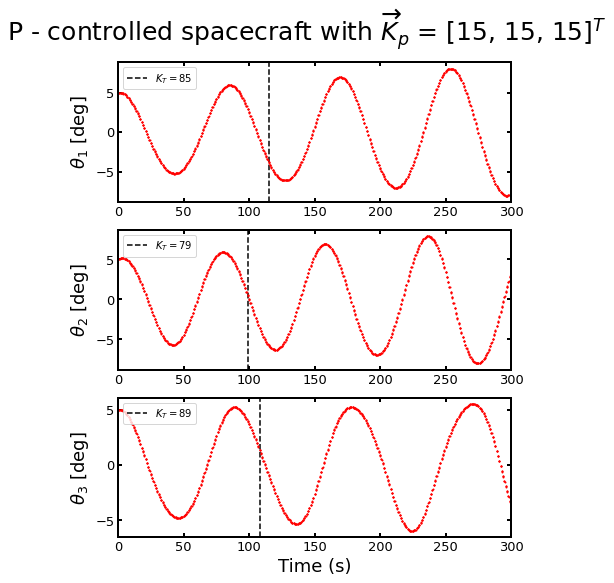

In [106]:
labels = [r"$\theta_1$ [deg]", r"$\theta_2$ [deg]", r"$\theta_3$ [deg]",
          "$\omega_1$ [deg/s]", "$\omega_2$ [deg/s]", "$\omega_3$ [deg/s]"]

fig, axes = plt.subplots(3, 1, figsize = (7, 8))
fig.tight_layout(pad=4)
fig.suptitle("P - controlled spacecraft with $\overrightarrow{K}_p$ = [15, 15, 15]$^T$" % period, fontsize = 25, y = 1.02)
fig.subplots_adjust(hspace=0.2)
axes[-1].set_xlabel("Time (s)", fontsize = 18)

# axes[0,0].axvline(85, linestyle = '--', color = 'k', label = "$K_T = 85$")
# axes[1,0].axvline(79, linestyle = '--', color = 'k', label = "$K_T = 79$")
# axes[2,0].axvline(89, linestyle = '--', color = 'k', label = "$K_T = 89$")

axes[0].axvline(115, linestyle = '--', color = 'k', label = "$K_T = 85$")
axes[1].axvline(99, linestyle = '--', color = 'k', label = "$K_T = 79$")
axes[2].axvline(108, linestyle = '--', color = 'k', label = "$K_T = 89$")

for ax in axes:
    ax.set_xlim(0, 300)
    ax.legend(loc = 'upper left')

for i, ax in enumerate(axes): 
    
    ax.plot(state_history_p[0][:,0], np.rad2deg(state_history_p[0][:,1+i]), 'ro', markersize = 1)
    ax.set_ylabel(labels[i], fontsize = 18) 
    #ax.axvline(81)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    ax.tick_params(labelsize=13)
    ax.tick_params(axis="both",direction="in",which="both", length=4, width = 2)
    ax.tick_params(bottom=True, top=True, left=True, right=True)

### Plotting the optimum of the deriavtive term

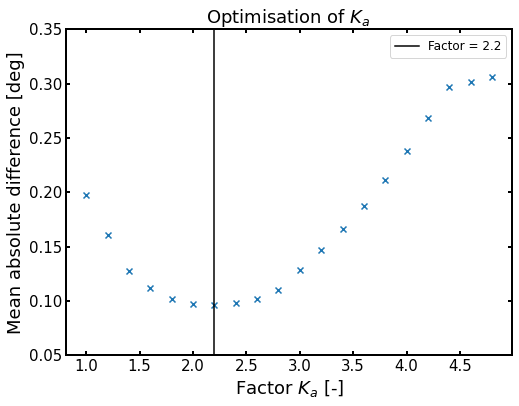

In [104]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.set_title("Optimisation of $K_a$ ", fontsize = 18)
plt.scatter(factors, np.rad2deg(metrics), marker = 'x') 
plt.xlabel("Factor $K_a$ [-]", fontsize = 18)
plt.ylabel("Mean absolute difference [deg]", fontsize = 18) 
plt.axvline(2.2, color='k', label = "Factor = 2.2")
plt.legend(fontsize = 12)
plt.ylim(0.05, 0.35)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(labelsize=15)
ax.tick_params(axis="both",direction="in",which="both", length=4, width = 2)
ax.tick_params(bottom=True, top=True, left=True, right=True)

In [103]:
def find_settle_times(data, thresh = np.deg2rad(0.1)): 
    
    time = data[:,0]
    settling_times = np.zeros(3)
    
    for i in range(1, 4):
        settling_time_index = np.where((np.abs(data[:,i]) < thresh) == False)[0][-1]
        settling_times[i-1] = time[settling_time_index + 1]
        
    return np.max(settling_times) 

### Plot the near optimal cases

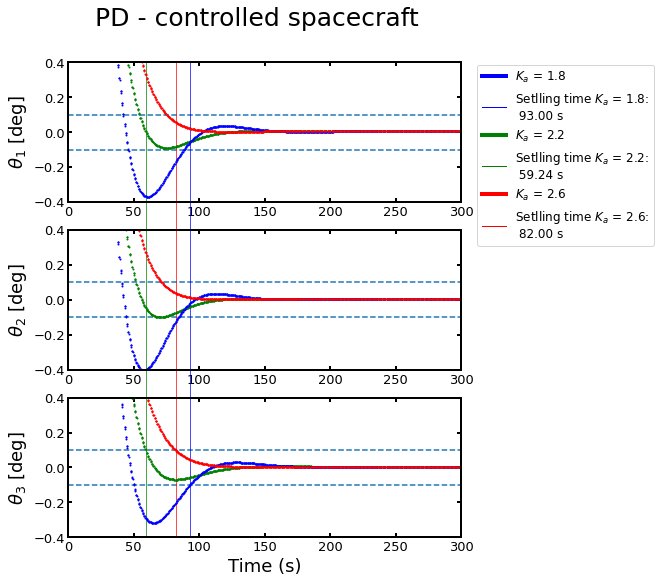

In [107]:
labels = [r"$\theta_1$ [deg]", r"$\theta_2$ [deg]", r"$\theta_3$ [deg]",
          "$\omega_1$ [deg/s]", "$\omega_2$ [deg/s]", "$\omega_3$ [deg/s]"]

fig, axes = plt.subplots(3, 1, figsize = (7, 8))
fig.tight_layout(pad=4)
fig.suptitle("PD - controlled spacecraft" % period, fontsize = 25, y = 1.02)
fig.subplots_adjust(hspace=0.2)
axes[2].set_xlabel("Time (s)", fontsize = 18)

for ax in axes:
    
    ax.axhline(-0.1, linestyle = '--')
    ax.axhline(0.1, linestyle = '--')
    
#     ax.set_xlim(0, 200)
#     ax.set_ylim(-5, 6)

    ax.set_xlim(0, 300)
    ax.set_ylim(-0.4, 0.4)

for ax in axes[:-1]:
    ax.axvline(find_settle_times(state_history_f22[0]), ymin=-0.4, ymax=1, color = 'g', linewidth = 0.7, clip_on=False)
    ax.axvline(find_settle_times(state_history_f3[0]), ymin=-0.4, ymax=1, color = 'r', linewidth = 0.7, clip_on=False)
    ax.axvline(find_settle_times(state_history_f14[0]), ymin=-0.4, ymax=1, color = 'b', linewidth = 0.7, clip_on=False)

axes[-1].axvline(find_settle_times(state_history_f22[0]), ymin=0, ymax=1, color = 'g', linewidth = 0.7, clip_on=False, label = "Setlling time $K_a$ = 2.2")
axes[-1].axvline(find_settle_times(state_history_f3[0]), ymin=0, ymax=1, color = 'r', linewidth = 0.7, clip_on=False)
axes[-1].axvline(find_settle_times(state_history_f14[0]), ymin=0, ymax=1, color = 'b', linewidth = 0.7, clip_on=False)  

for i, ax in enumerate(axes.T.flat): 
    
    ax.plot(state_history_f22[0][:,0], np.rad2deg(state_history_f22[0][:,1+i]), 'go', markersize = 1, label = "$K_a$ = 2.2")
    ax.plot(state_history_f14[0][:,0], np.rad2deg(state_history_f14[0][:,1+i]), 'bo', markersize = 1, label = "$K_a$ = 1.4")
    ax.plot(state_history_f3[0][:,0], np.rad2deg(state_history_f3[0][:,1+i]), 'ro', markersize = 1, label = "$K_a$ = 3.0")


    
    ax.set_ylabel(labels[i], fontsize = 18) 
    #ax.axvline(81)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    ax.tick_params(labelsize=13)
    ax.tick_params(axis="both",direction="in",which="both", length=4, width = 2)
    ax.tick_params(bottom=True, top=True, left=True, right=True)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='b', lw=1),
                Line2D([0], [0], color='g', lw=4), 
                Line2D([0], [0], color='g', lw=1),
               Line2D([0], [0], color='r', lw=4),
               Line2D([0], [0], color='r', lw=1)]

fig.legend(custom_lines, ["$K_a$ = 1.8", "Setlling time $K_a$ = 1.8:\n %.2f s" % find_settle_times(state_history_f14[0]),
                          "$K_a$ = 2.2", "Setlling time $K_a$ = 2.2:\n %.2f s" % find_settle_times(state_history_f22[0]),
                          "$K_a$ = 2.6", "Setlling time $K_a$ = 2.6:\n %.2f s" % find_settle_times(state_history_f3[0])], 
           bbox_to_anchor = (1.3, 0.93), fontsize = 12)